_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 3

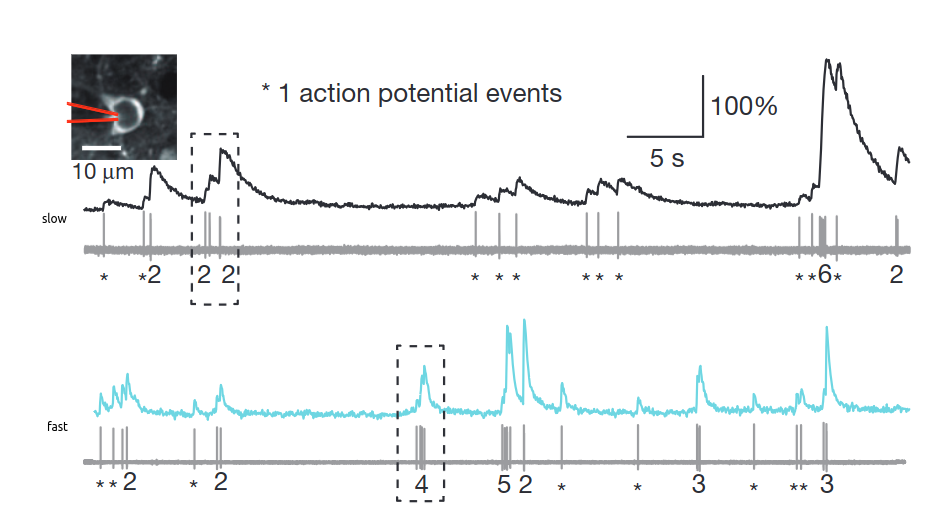

In this notebook you will work with 2 photon calcium recordings from mouse V1 and retina. For details see [Chen et al. 2013](https://www.nature.com/articles/nature12354) and [Theis et al. 2016](https://www.cell.com/neuron/pdf/S0896-6273(16)30073-3.pdf). Two-photon imaging is widely used to study computations in populations of neurons. 

In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For easier analysis, please resample it to 25 Hz. `scipy.signal.decimate` can help here, but note that it is only meant for continous signals. 

__Data__: Download the data file ```nds_cl_3_*.csv``` from ILIAS and save it in a subfolder ```../data/```. Note, some recordings were of shorter duration, hence their columns are padded. 

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.signal import decimate, lfilter
from __future__ import annotations

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-05-10 15:14:05CEST

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.21.0

sklearn: 1.3.2

seaborn   : 0.13.0
scipy     : 1.11.4
matplotlib: 3.8.0
numpy     : 1.26.2
pandas    : 2.2.3

Watermark: 2.5.0



In [3]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [4]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0)
ogb_spikes = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0)
print(f"[OGB] calcium: {ogb_calcium.shape}, spikes: {ogb_spikes.shape}")

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0)
gcamp_spikes = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0)
print(f"[GCaMP] calcium: {gcamp_calcium.shape}, spikes: {gcamp_spikes.shape}")

# spike dataframe
ogb_spikes.head()

[OGB] calcium: (71986, 11), spikes: (71986, 11)
[GCaMP] calcium: (23973, 37), spikes: (23973, 37)


,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
1,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
2,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
3,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
4,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0


## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. For the CGamp-dataset a good example is cell 6. Align the traces by eye (add a small offset to the plot) such that a valid comparison is possible and zoom in on a small segment of tens of seconds.

*Grading: 3 pts*

/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_6707/1752787609.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.interpolate(axis=0).fillna(method="bfill").fillna(method="ffill")
/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_6707/1752787609.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.interpolate(axis=0).fillna(method="bfill").fillna(method="ffill")
/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_6707/1752787609.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.interpolate(axis=0).fillna(method="bfill").fillna(method="ffill")
/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_6707/1752787609.py:12: FutureWarning: DataFrame.filln

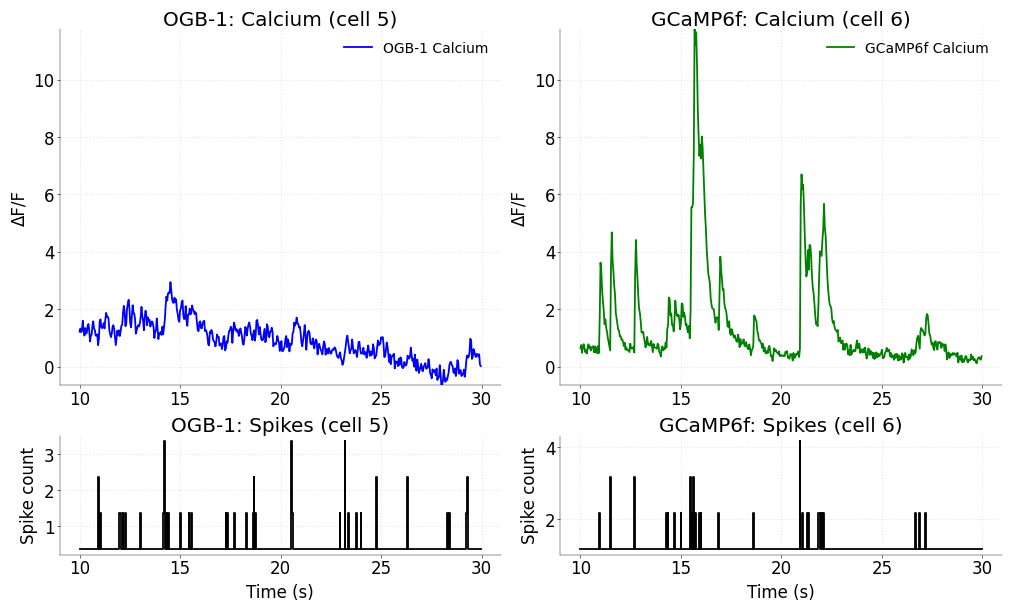

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import decimate

# --------------------------------
# Resample and prepare data (1 pt)
# --------------------------------


# CLEAN: interpolate and fill any NaNs
def clean_df(df):
    return df.interpolate(axis=0).fillna(method="bfill").fillna(method="ffill")


ogb_cal = clean_df(ogb_calcium)
ogb_spk = clean_df(ogb_spikes)
gcamp_cal = clean_df(gcamp_calcium)
gcamp_spk = clean_df(gcamp_spikes)

# DOWNSAMPLING FUNCTIONS
DOWNSAMPLE_FACTOR = 4  # 100 Hz → 25 Hz


def downsample_calcium(df):
    """Zero-phase FIR decimation of each continuous trace."""
    return df.apply(
        lambda col: decimate(
            col.values, DOWNSAMPLE_FACTOR, ftype="fir", zero_phase=True
        ),
        axis=0,
        result_type="expand",
    ).set_axis(df.columns, axis=1)


def downsample_spikes(df):
    """Bin & sum integer spike counts into non-overlapping windows."""
    arr = df.values
    n_bins = arr.shape[0] // DOWNSAMPLE_FACTOR
    arr = arr[: n_bins * DOWNSAMPLE_FACTOR]
    binned = arr.reshape(n_bins, DOWNSAMPLE_FACTOR, arr.shape[1]).sum(axis=1)
    return pd.DataFrame(binned, columns=df.columns)


# APPLY DOWNSAMPLING
ogb_cal_ds = downsample_calcium(ogb_cal)
ogb_spk_ds = downsample_spikes(ogb_spk)
gcamp_cal_ds = downsample_calcium(gcamp_cal)
gcamp_spk_ds = downsample_spikes(gcamp_spk)

# DEFINE SEGMENT & TIME VECTOR
start_t, end_t = 10, 30  # seconds
sr_new = 25  # Hz after downsampling
start_idx = start_t * sr_new
end_idx = end_t * sr_new
time = np.linspace(start_t, end_t, end_idx - start_idx, endpoint=False)

cell_ogb, cell_gcamp = 5, 6

# EXTRACT SEGMENTS
ogb_cal_seg = ogb_cal_ds.iloc[start_idx:end_idx, cell_ogb]
ogb_spk_seg = ogb_spk_ds.iloc[start_idx:end_idx, cell_ogb]
gcamp_cal_seg = gcamp_cal_ds.iloc[start_idx:end_idx, cell_gcamp]
gcamp_spk_seg = gcamp_spk_ds.iloc[start_idx:end_idx, cell_gcamp]

# DYNAMIC OFFSETS FOR SPIKES
offset_ogb = 0.1 * (ogb_cal_seg.max() - ogb_cal_seg.min())
offset_gcamp = 0.1 * (gcamp_cal_seg.max() - gcamp_cal_seg.min())

# --------------------
# Plot OGB data (1 pt)
# --------------------


# ----------------------
# Plot GCamp data (1 pt)
# ----------------------


plt.rcParams.update(
    {
        "font.size": 12,
        "lines.linewidth": 1.3,
    }
)

fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(10, 6),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

# Top-left: OGB-1 calcium (blue)
axs[0, 0].plot(time, ogb_cal_seg, color="blue", label="OGB-1 Calcium")
axs[0, 0].set_title("OGB-1: Calcium (cell 5)")
axs[0, 0].set_ylabel("ΔF/F")
axs[0, 0].legend(loc="upper right")

# Top-right: GCaMP6f calcium (green)
axs[0, 1].plot(time, gcamp_cal_seg, color="green", label="GCaMP6f Calcium")
axs[0, 1].set_title("GCaMP6f: Calcium (cell 6)")
axs[0, 1].set_ylabel("ΔF/F")
axs[0, 1].legend(loc="upper right")

# Match y-limits on both calcium panels
ymin = min(ogb_cal_seg.min(), gcamp_cal_seg.min())
ymax = max(ogb_cal_seg.max(), gcamp_cal_seg.max())
for ax in (axs[0, 0], axs[0, 1]):
    ax.set_ylim(ymin, ymax)

# Bottom-left: OGB-1 spikes (black)
axs[1, 0].step(
    time, ogb_spk_seg + offset_ogb, where="mid", color="black", label="_nolegend_"
)
axs[1, 0].set_title("OGB-1: Spikes (cell 5)")
axs[1, 0].set_xlabel("Time (s)")
axs[1, 0].set_ylabel("Spike count")

# Bottom-right: GCaMP6f spikes (black)
axs[1, 1].step(
    time, gcamp_spk_seg + offset_gcamp, where="mid", color="black", label="_nolegend_"
)
axs[1, 1].set_title("GCaMP6f: Spikes (cell 6)")
axs[1, 1].set_xlabel("Time (s)")
axs[1, 1].set_ylabel("Spike count")

# Add subtle gridlines
for ax in axs.flatten():
    ax.grid(alpha=0.3, linestyle=":")

# Save & show
fig.savefig("task1_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

## Bonus Task (Optional): Calcium preprocessing

To improve the quality of the inferred spike trains, further preprocessing steps can undertaken. This includes filtering and smoothing of the calcium trace.

Implement a suitable filter and local averaging procedure as discussed in the lecture. Explain your choices and discuss how it helps!

_Grading: 1 BONUS point_

_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

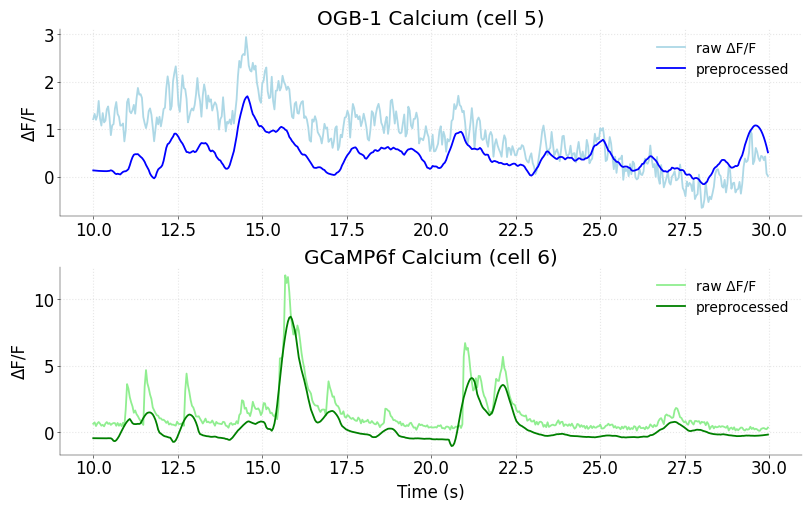

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, savgol_filter


# PARAMETERS
fs = 25  # Hz (after downsampling)
hp_cutoff = 0.01  # Hz, to remove very slow drifts
savgol_window = 21  # samples (~0.6 s window)
savgol_poly = 2  # quadratic fit for Savitzky–Golay

# DESIGN A HIGH-PASS BUTTERWORTH FILTER
b_hp, a_hp = butter(N=2, Wn=hp_cutoff / (fs / 2), btype="highpass")


def preprocess_calcium(trace: np.ndarray) -> np.ndarray:
    """
    (1) Zero-phase high-pass filter to strip slow drifts.
    (2) Savitzky–Golay smoothing to suppress high-frequency noise
        while preserving transient shape.
    """
    # remove DC offset
    centered = trace - np.nanmean(trace)
    # high-pass
    hp = filtfilt(b_hp, a_hp, centered)
    # Savitzky–Golay smoothing
    sg = savgol_filter(hp, savgol_window, polyorder=savgol_poly, mode="interp")
    return sg


# APPLY TO SEGMENTS
ogb_cal_filt = preprocess_calcium(ogb_cal_seg.values)
gcamp_cal_filt = preprocess_calcium(gcamp_cal_seg.values)

# PLOT RAW vs PREPROCESSED
fig, axs = plt.subplots(2, 1, figsize=(8, 5), constrained_layout=True)
t = time  # your 10–30 s time vector

# OGB-1 panel
axs[0].plot(t, ogb_cal_seg, color="lightblue", label="raw ΔF/F")
axs[0].plot(t, ogb_cal_filt, color="blue", label="preprocessed")
axs[0].set_title("OGB-1 Calcium (cell 5)")
axs[0].set_ylabel("ΔF/F")
axs[0].legend()
axs[0].grid(alpha=0.3, linestyle=":")

# GCaMP6f panel
axs[1].plot(t, gcamp_cal_seg, color="lightgreen", label="raw ΔF/F")
axs[1].plot(t, gcamp_cal_filt, color="green", label="preprocessed")
axs[1].set_title("GCaMP6f Calcium (cell 6)")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("ΔF/F")
axs[1].legend()
axs[1].grid(alpha=0.3, linestyle=":")

plt.show()

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). Note there can be no negative rates! Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons. You can use functions from `scipy` for this. Explain your results and your choice of kernel.

*Grading: 6 pts*


In [31]:
def deconv_ca(ca: np.ndarray, tau: float, dt: float) -> np.ndarray:
    """Compute the deconvolution of the calcium signal.

    Parameters
    ----------

    ca: np.array, (n_points,)
        Calcium trace

    tau: float
        decay constant of conv kernel

    dt: float
        sampling interval.

    Return
    ------
    C_t = alpha * C_{t-1} + s_t  -->  s_t = C_t - alpha * C_{t-1}

    sp_hat: np.array
    """

    # --------------------------------------------
    # apply devonvolution to calcium signal (1 pt)
    # --------------------------------------------

    alpha = np.exp(-dt / tau)
    # s[t] = 1*C[t] + (-alpha)*C[t-1]
    sp_hat = lfilter(b=[1, -alpha], a=[1], x=ca)
    # no negative rates
    sp_hat = np.clip(sp_hat, 0, None)
    return sp_hat

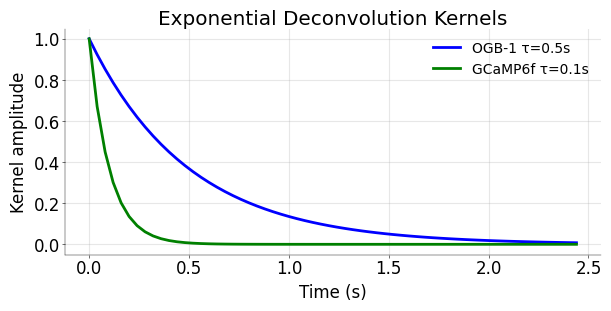

In [34]:
# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------
tau_ogb = 0.5  # s (OGB-1 decay)
tau_gcamp = 0.1  # s (GCaMP6f decay)
sr = 25  # sampling rate (Hz)
dt = 1 / sr

# build 5τ-long impulse responses
N = int(5 * max(tau_ogb, tau_gcamp) / dt)
t_k = np.arange(N) * dt
h_ogb = np.exp(-t_k / tau_ogb)
h_gcamp = np.exp(-t_k / tau_gcamp)

fig, ax = plt.subplots(figsize=(6, 3), constrained_layout=True)
ax.plot(t_k, h_ogb, lw=2, color="blue", label=f"OGB-1 τ={tau_ogb}s")
ax.plot(t_k, h_gcamp, lw=2, color="green", label=f"GCaMP6f τ={tau_gcamp}s")
ax.set_title("Exponential Deconvolution Kernels")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Kernel amplitude")
ax.legend(frameon=False)
ax.grid(alpha=0.3)
plt.show()

### Questions (1 pt)
1) Explain how you constructed the kernels

YOUR ANSWER HERE

2) How do the indicators / kernels compare?

YOUR ANSWER HERE

3) What are pros and cons of each indicator?

YOUR ANSWER HERE

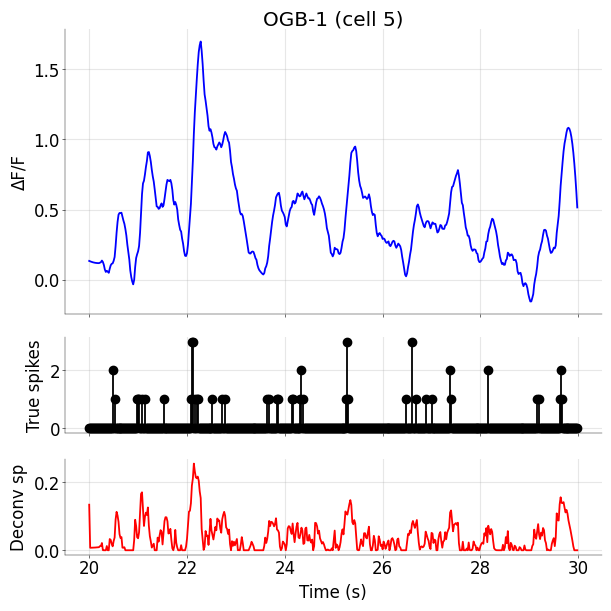

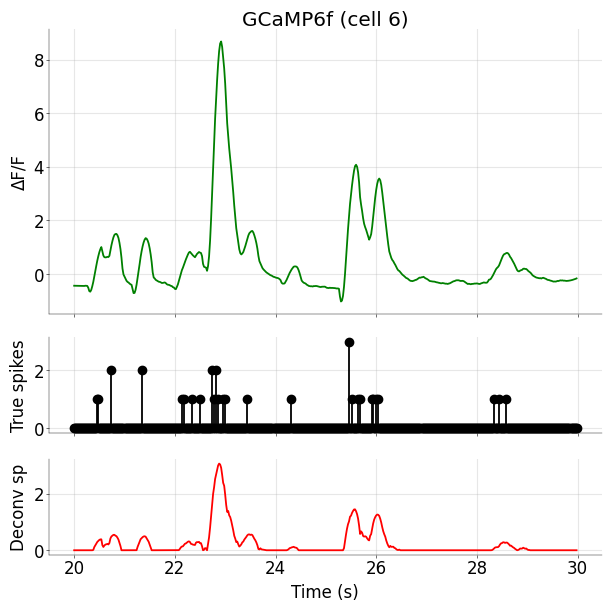

In [36]:
# ----------------------------------------------------------------------
# Compare true and deconvolved spike rates for the OGB and GCaMP cells.
# What do you notice? Why is that? (3 pts)
# ----------------------------------------------------------------------

# Run deconvolution on our preprocessed calcium segments ---
sp_hat_ogb = deconv_ca(ogb_cal_filt, tau=tau_ogb, dt=dt)
sp_hat_gcamp = deconv_ca(gcamp_cal_filt, tau=tau_gcamp, dt=dt)

# Time window & vector
t0, t1 = 20, 30
n_pts_ogb = len(ogb_cal_filt)
time_ogb = np.linspace(t0, t1, n_pts_ogb, endpoint=False)

# Plot 3×1 for OGB-1 ---
fig, axs = plt.subplots(
    3,
    1,
    figsize=(6, 6),
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1, 1], "hspace": 0.1},
    constrained_layout=True,
)

# Preprocessed ΔF/F (not raw!)
axs[0].plot(time_ogb, ogb_cal_filt, color="blue")
axs[0].set_ylabel("ΔF/F")
axs[0].set_title("OGB-1 (cell 5)")

# True spikes
axs[1].stem(time_ogb, ogb_spk_seg, linefmt="k-", markerfmt="ko", basefmt=" ")
axs[1].set_ylabel("True spikes")

# Deconvolved estimate
axs[2].plot(time_ogb, sp_hat_ogb, color="red")
axs[2].set_ylabel("Deconv sp")
axs[2].set_xlabel("Time (s)")

for ax in axs:
    ax.grid(alpha=0.3)

plt.show()


## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 3 pts*



In [ ]:
# run this cell to download the oopsi.py file and put it in the same folder as this notebook
!wget https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py
import oopsi

In [66]:
# ----------------------------------------------------------------------
# Apply one of the advanced algorithms to the OGB and GCamp Cells (1 pt)
# ----------------------------------------------------------------------
from oasis.functions import deconvolve


# Define a simple Oasis wrapper 
def run_oasis(trace, penalty=1.0):
    _, s, _, _, _ = deconvolve(trace, penalty=penalty, optimize_g=False)
    return s


# Parameters and indices
fs = 25  # sampling rate after downsampling (Hz)
t0, t1 = 20.0, 30.0  # window in seconds
i0, i1 = int(t0 * fs), int(t1 * fs)  # sample indices 500 → 750
time = np.linspace(t0, t1, i1 - i0, endpoint=False)  # 250 points

cell_ogb = 5  # example OGB cell index
cell_gcamp = 6  # example GCaMP cell index

# Grab full preprocessed ΔF/F and ground‐truth spikes from Task 1
full_ca_ogb = ogb_cal_ds.iloc[:, cell_ogb].values
full_spk_ogb = ogb_spk_ds.iloc[:, cell_ogb].values

full_ca_gcamp = gcamp_cal_ds.iloc[:, cell_gcamp].values
full_spk_gcamp = gcamp_spk_ds.iloc[:, cell_gcamp].values

# Run OASIS deconvolution on the full traces
c_ogb_full, s_ogb_full, *_ = deconvolve(full_ca_ogb, penalty=1.0, optimize_g=False)
c_gcamp_full, s_gcamp_full, *_ = deconvolve(
    full_ca_gcamp, penalty=1.0, optimize_g=False
)

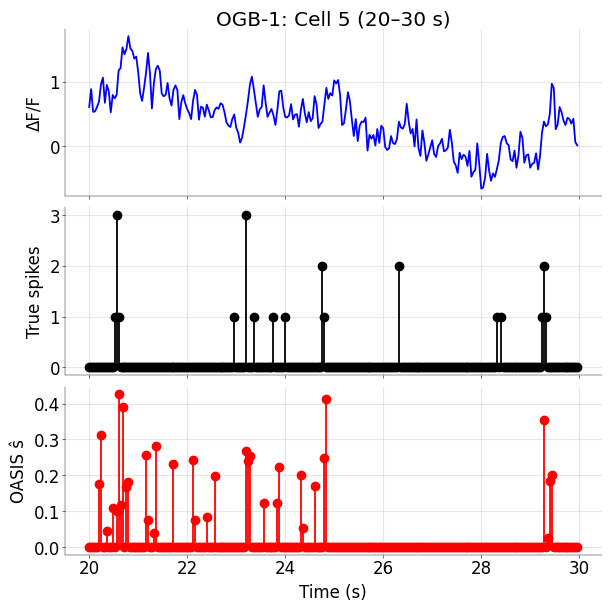

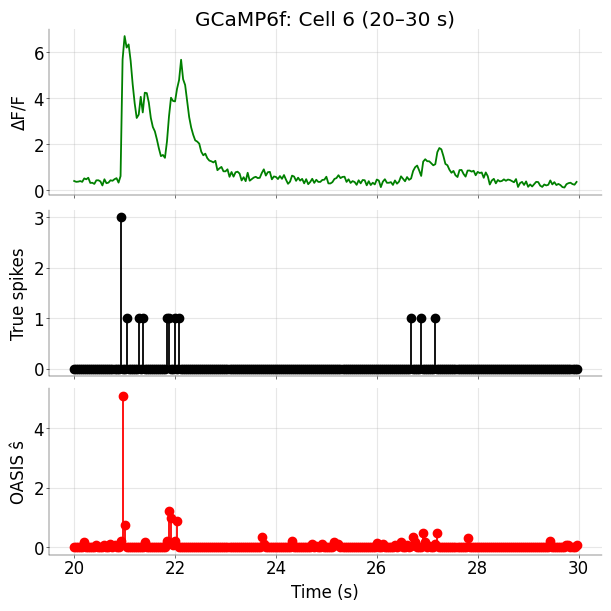

In [65]:
# -------------------------------------------------------------------------------
# Plot the results for the OGB and GCaMP Cells and describe the results (1+1 pts)
# -------------------------------------------------------------------------------

# 4) Slice out exactly 20–30 s (250 samples)
seg_ca_ogb = full_ca_ogb[i0:i1]
seg_true_ogb = full_spk_ogb[i0:i1]
seg_hat_ogb = s_ogb_full[i0:i1]

seg_ca_gcamp = full_ca_gcamp[i0:i1]
seg_true_gcamp = full_spk_gcamp[i0:i1]
seg_hat_gcamp = s_gcamp_full[i0:i1]

# Plot OGB-1 results (3×1)
fig, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True, constrained_layout=True)
axs[0].plot(time, seg_ca_ogb, color="blue")
axs[0].set_ylabel("ΔF/F")
axs[0].set_title("OGB-1: Cell 5 (20–30 s)")
axs[1].stem(time, seg_true_ogb, linefmt="k-", markerfmt="ko", basefmt=" ")
axs[1].set_ylabel("True spikes")
axs[2].stem(time, seg_hat_ogb, linefmt="r-", markerfmt="ro", basefmt=" ")
axs[2].set_ylabel("OASIS ŝ")
axs[2].set_xlabel("Time (s)")
for ax in axs:
    ax.grid(alpha=0.3)
plt.show()

# Plot GCaMP6f results (3×1)
fig, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True, constrained_layout=True)
axs[0].plot(time, seg_ca_gcamp, color="green")
axs[0].set_ylabel("ΔF/F")
axs[0].set_title("GCaMP6f: Cell 6 (20–30 s)")
axs[1].stem(time, seg_true_gcamp, linefmt="k-", markerfmt="ko", basefmt=" ")
axs[1].set_ylabel("True spikes")
axs[2].stem(time, seg_hat_gcamp, linefmt="r-", markerfmt="ro", basefmt=" ")
axs[2].set_ylabel("OASIS ŝ")
axs[2].set_xlabel("Time (s)")
for ax in axs:
    ax.grid(alpha=0.3)
plt.show()

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package. Note these functions provide useful options for formatting the
plots. See their documentation, i.e. `sns.boxplot?`.

*Grading: 5 pts*


First, evaluate on OGB data and create OGB dataframe. Then repeat for GCamp and combine the two dataframes.

In [ ]:
# ----------------------------------------------------------
# Evaluate the algorithms on the OGB and GCamp cells (2 pts)
# ----------------------------------------------------------

In [ ]:
# -------------------------------
# Construct the dataframe (1 pts)
# -------------------------------

Combine both dataframes. Plot the performance of each indicator and algorithm. You should only need a single plot for this.

In [ ]:
# ----------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described. (1 pt)
# Describe and explain the results briefly. (1 pt)
# ----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")
